In [1]:
# Import statements for connecting to google cloud. This should give you a link
# for authentication. Click on the link and sign in with your google account
# that is connected to the google bucket containing your data.
from google.colab import auth
from google.cloud import storage
auth.authenticate_user()

# First, we need to set our project. Replace the assignments below with the
# project ID and bucket name to access for your data.
project_id = 'humanitarian-tent'
bucket_name = 'tent-bucket'
!gcloud config set project {project_id}
client = storage.Client(project_id)
bucket = client.get_bucket(bucket_name)

Updated property [core/project].


4) Finetuning a Pretrained Detection Model
============================================

Fine-tuning is a commonly used approach to transfer previously trained model to a new dataset. It is especially useful if the targeting new dataset is relatively small. Finetuning from pre-trained models can help reduce the risk of overfitting and can also generalize better if the previously used dataset is in the similar domain of the new dataset (good use of transfer learning).

This colab fine-tunes object detection models provided by GluonCV for the purpose of detecting humanitarian structures in satellite imagery. This is the fourth step of our modeling project, following: 1) **Pulling Data from Digital Globe**; 2) **Processing Satellite Image in to Training Data**; 3) **TFRecord Conversion**.

Note that **all code in this record can be run on a colab runtime** and the only data dependency is the data in the connected google bucket folder. For running on a local run time, the first cell does not need to be executed. For running on a remove VM in Google Cloud, follow the pre-stage colab, **Setting Up Colab Interface for Google Cloud VM**.


In [2]:
# The '!' commands execute on the machine, so this will install all the required
# dependencies for training your model. For this project, we will be using the
# mxnet platform (https://mxnet.apache.org/) for learning and the gluoncv
# (https://gluon-cv.mxnet.io/) which is a toolkit for computer vision on mxnet. 
!pip install mxnet>=1.3.0 --upgrade
!pip install gluoncv --upgrade

# Other libraries we will be using
import time
from matplotlib import pyplot as plt
import numpy as np
import mxnet as mx
from mxnet import autograd, gluon
import gluoncv as gcv
from gluoncv.utils import download, viz
import datetime 

Requirement already up-to-date: gluoncv in /usr/local/lib/python3.6/dist-packages (0.3.0)


## Load the Humanitarian Structure Dataset

Since all of our data is store in tfrecord format on the cloud, we have to go through a few steps to convert it to the necessary format to run with Gluon/MXNET.

Here, we first download all of the tfrecord files locally (they are in binary/compressed format so it should take max 1 minute, even for the larger datasets).

Then, we use a custom class we wrote (TFRecordFileDataset) to extract the images and labels (bounding boxes + labels) in the compatible format for modeling with Gluon. The dataset that this class wraps can then be used directly as input in to training.


In [3]:
# Note that these file directories are based on the STEP 3: TFRecord Conversion
# notebook. If you wrote your tfrecords in to different file directories please
# replace all the paths below with your custom filepaths.

TF_RECORD_PREFIX = 'tf_records_100'
IM_SIZE = 100
REGION = 'Africa2'
TRAIN_FILES = ['%s/%s/train.tfrecord-0000%d-of-00010' % (
    TF_RECORD_PREFIX, REGION, i) for i in range(10)]
VAL_FILES = ['%s/%s/val.tfrecord-0000%d-of-00010' % (
    TF_RECORD_PREFIX, REGION, i) for i in range(10)]

def to_local(fp):
  """
  Simple mapping function to simplify nested filepaths in the google bucket
  """
  return '_'.join(fp.split('/'))

def upload_files(bucket, files, mapping_fn=to_local):
  """
  This function will take a list of files in a google bucket and upload them
  locally using a simple linearizing mapping function (default is to_local)
  """
  for f in files:
    blob = bucket.get_blob(f)
    with open(mapping_fn(f), 'wb') as obj:
      blob.download_to_file(obj)
    print("Finished %s" % f)

# Upload all TFRecord files locally so we have access to them for training
upload_files(bucket, TRAIN_FILES + VAL_FILES)
local_train_files = [to_local(f) for f in TRAIN_FILES]
local_val_files = [to_local(f) for f in VAL_FILES]

Finished tf_records_100/Africa2/train.tfrecord-00000-of-00010
Finished tf_records_100/Africa2/train.tfrecord-00001-of-00010
Finished tf_records_100/Africa2/train.tfrecord-00002-of-00010
Finished tf_records_100/Africa2/train.tfrecord-00003-of-00010
Finished tf_records_100/Africa2/train.tfrecord-00004-of-00010
Finished tf_records_100/Africa2/train.tfrecord-00005-of-00010
Finished tf_records_100/Africa2/train.tfrecord-00006-of-00010
Finished tf_records_100/Africa2/train.tfrecord-00007-of-00010
Finished tf_records_100/Africa2/train.tfrecord-00008-of-00010
Finished tf_records_100/Africa2/train.tfrecord-00009-of-00010
Finished tf_records_100/Africa2/val.tfrecord-00000-of-00010
Finished tf_records_100/Africa2/val.tfrecord-00001-of-00010
Finished tf_records_100/Africa2/val.tfrecord-00002-of-00010
Finished tf_records_100/Africa2/val.tfrecord-00003-of-00010
Finished tf_records_100/Africa2/val.tfrecord-00004-of-00010
Finished tf_records_100/Africa2/val.tfrecord-00005-of-00010
Finished tf_records_

In [0]:
import tensorflow as tf
from PIL import Image
from io import BytesIO

classes_dict = {
  b'UNHCR Tent': 0,
  b'Administrative Structure': 1,
  b'Other Tent': 2,
  b'Round Earthen Structure': 3
}

class TFRecordFileDataset(mx.gluon.data.Dataset):
  """A dataset wrapping over a TFRecord files.

  Each sample is a string representing the raw content of an record. Parsing and
  other formatting logic occurs on each __get_item__ call runtime. Note that we
  also ignore any images that seem invalid (e.g. empty, out of range numbers,
  NaN values, etc.)

  Parameters
  ----------
  files : TFRecord filepaths
  filter_unlabeled: Boolean for filtering on images containing no bounding
          boxes. Note that this must be set to true for training, since non-
          labelled images are invalid examples, however it does not need to be
          set true for inference
  use_classes: Whether to use the class types for labels or combine them all in
          to a single class
  """
  def __init__(self, files, filter_unlabeled=True, use_classes=False):
    self._record = []
    self.use_classes = use_classes
    for file in files:
      for example in tf.python_io.tf_record_iterator(file):
        result = tf.train.Example.FromString(example)
        image_data = result.features.feature[
            'image/encoded'].bytes_list.value[0]
        im = np.frombuffer(image_data, dtype=np.uint8)
        if np.any(np.isnan(im)):
          print("Skipping image from nan")
          continue
        if np.any(im < 0):
          print("Min of image is %0.2f .. skipping" % np.min(im))
          continue
        if np.any(im > 255.):
          print("Max of image is %0.2f .. skipping" % np.max(im))
          continue
        if np.mean(im) < 1:
          print("Mean of image is %0.2f .. skipping" % np.mean(im))
          continue
        if im.size != IM_SIZE*IM_SIZE*3:
          print("Size of image is %d .. skipping" % im.size)
        if (not filter_unlabeled) or len(result.features.feature[
            'image/object/point/x'].int64_list.value) > 0:
          self._record.append(result)


  def __getitem__(self, idx):
    """
    In this method we overwrite the default index function to take our stored
    binary TFExample representation of the example and extract relevant
    features/labels. Our TFExample should include the encoded image under the
    key 'image/encoded'for a bytes_list and the x and y positions (not
    normalized) of each structure encoded under the keys 'image/object/point/x'
    and 'image/object/point/y' respectively for an int64_list.
    If use_classes was set to True on initialization, this function also expects
    the class value (defined in classes_dict) under the key
    'image/object/class/text' for a bytes_list.
    """
    result = self._record[idx]
    image_data = result.features.feature['image/encoded'].bytes_list.value[0]
    im = np.frombuffer(image_data, dtype=np.uint8)
    im = mx.nd.array(im).reshape((IM_SIZE, IM_SIZE, 3))
    x = np.array(
        result.features.feature['image/object/point/x'].int64_list.value)
    y = np.array(
        result.features.feature['image/object/point/y'].int64_list.value)
    if self.use_classes:
      classes = np.array(
          [classes_dict[x] for x in result.features.feature[
              'image/object/class/text'].bytes_list.value])
    else:
      classes = np.zeros_like(x)
    if x.size > 0:
      label = np.stack(
          [x-10, y-10, x+10, y+10, classes], axis=1).astype(np.float32)
    else:
      label = np.empty((0,5))
    return im, label

  def __len__(self):
      return len(self._record)

In [0]:
def show_examples(net, train_dataset, val_dataset, num_examples=1,
                  threshold=0.5, fn=lambda x,y,z:(x[0],y[0],z[0])):
  """
  This method is a simple visualization of a variable number of examples from
  two different datasets (recommended for train/validation comparison). This
  function will randomly select num_examples from the two datasets and run the
  net over the examples. It will then display:
  1) example from the first dataset with labels
  2) example from the first dataset with predictions
  3) example from the second dataset with labels
  4) example from the second dataset with predictions
  The function also supports a variable threshold for displaying prediction
  boxes from the net and a lambda conversion function to further manipulate the
  raw output predictions from the net before visualization.
  """

  fig, axes = plt.subplots(num_examples, 4, figsize=(4*4, 4*num_examples))
  
  for i in range(num_examples):
    
    # Train Dataset
    image, label = train_dataset[np.random.randint(len(train_dataset))]
    x, image = gcv.data.transforms.presets.ssd.transform_test(image, IM_SIZE)
    cid, score, bbox = net(x)
    if fn is not None:
      bbox, score, cid = fn(bbox, score, cid)

    _ = viz.plot_bbox(image, bboxes=label[:, :4], labels=label[:, 4:5],
                      class_names=classes, ax=axes[i, 0])
    _ = viz.plot_bbox(image, bbox, score, cid, class_names=classes,
                      ax=axes[i, 1], thresh=threshold)
    axes[i, 0].axis('off')
    axes[i, 0].title.set_text('Original (train)')
    axes[i, 1].axis('off')
    axes[i, 1].title.set_text('Predicted (train)')

    # Validation Dataset
    image, label = val_dataset[np.random.randint(len(val_dataset))]
    x, image = gcv.data.transforms.presets.ssd.transform_test(image, IM_SIZE)
    cid, score, bbox = net(x)
    if fn is not None:
      bbox, score, cid = fn(bbox, score, cid)

    _ = viz.plot_bbox(image, bboxes=label[:, :4], labels=label[:, 4:5],
                      class_names=classes, ax=axes[i, 2])
    _ = viz.plot_bbox(image, bbox, score, cid, class_names=classes,
                      ax=axes[i, 3], thresh=threshold)
    axes[i, 2].axis('off')
    axes[i, 2].title.set_text('Original (validation)')
    axes[i, 3].axis('off')
    axes[i, 3].title.set_text('Predicted (validation)')
  
  plt.show()

In [0]:
def get_dataloader(net, train_dataset, data_shape, batch_size, num_workers):
  """
  This funciton creates the native dataloader for MXnet. Note that the data
  loader is very similar to TFRecord Dataset, in that it creates a computation
  graph but doesn't actually load/process any data until runtime.
  """
  from gluoncv.data.batchify import Tuple, Stack, Pad
  from gluoncv.data.transforms.presets.ssd import SSDDefaultTrainTransform
  width, height = data_shape, data_shape
  # Use fake data to generate fixed anchors for target generation
  with autograd.train_mode():
      _, _, anchors = net(mx.nd.zeros((1, 3, height, width)))
  # Stack image, cls_targets, box_targets
  batchify_fn = Tuple(Stack(), Stack(), Stack())
  train_loader = gluon.data.DataLoader(
      train_dataset.transform(SSDDefaultTrainTransform(width, height, anchors)),
      batch_size, True, batchify_fn=batchify_fn, last_batch='rollover',
      num_workers=num_workers)
  return train_loader

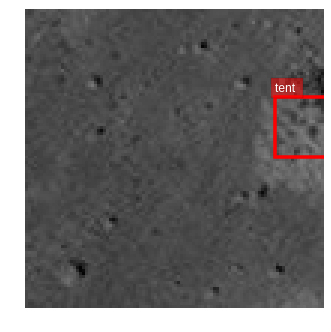

In [7]:
# Create the MXnet datasets for training and validation
train_dataset = TFRecordFileDataset(local_train_files)
# For validation dataset, don't filter on examples with zero labeled boxes
val_dataset = TFRecordFileDataset(local_val_files, filter_unlabeled=False)

classes = ['tent']  # only one foreground class here
# Uncomment below if you are visualizing and creating classes in the dataset
# classes = [x.decode() for x in list(classes_dict.keys())]

# Retrieve an example and display the image and label
image, label = train_dataset[0]
ax = viz.plot_bbox(image, bboxes=label[:, :4], labels=label[:, 4:5], class_names=classes)
plt.axis('off')
plt.show()

Pre-Trained Models
-------------------
In this section, we take a pre-trained model and train this model on our data. For this example, we use a SSD network with a Resnet backbone pre-trained on Pascal VOC. However, there are lots of choices from `gluoncv-model-zoo-detection` Model Zoo for object detection. Anything ending with 'voc' should work out of the box, but other models may require some extra tweaks to fit with the data.



In [0]:
MODEL = 'ssd_512_resnet50_v1_voc'

In [0]:
# Get the model from Gluon CV's model zoo and reset the classes to our classes
net = gcv.model_zoo.get_model(MODEL, pretrained=True)
net.reset_class(classes)
# Now the output layers that used to map to VOC classes are reset to distinguish
# our classes only.

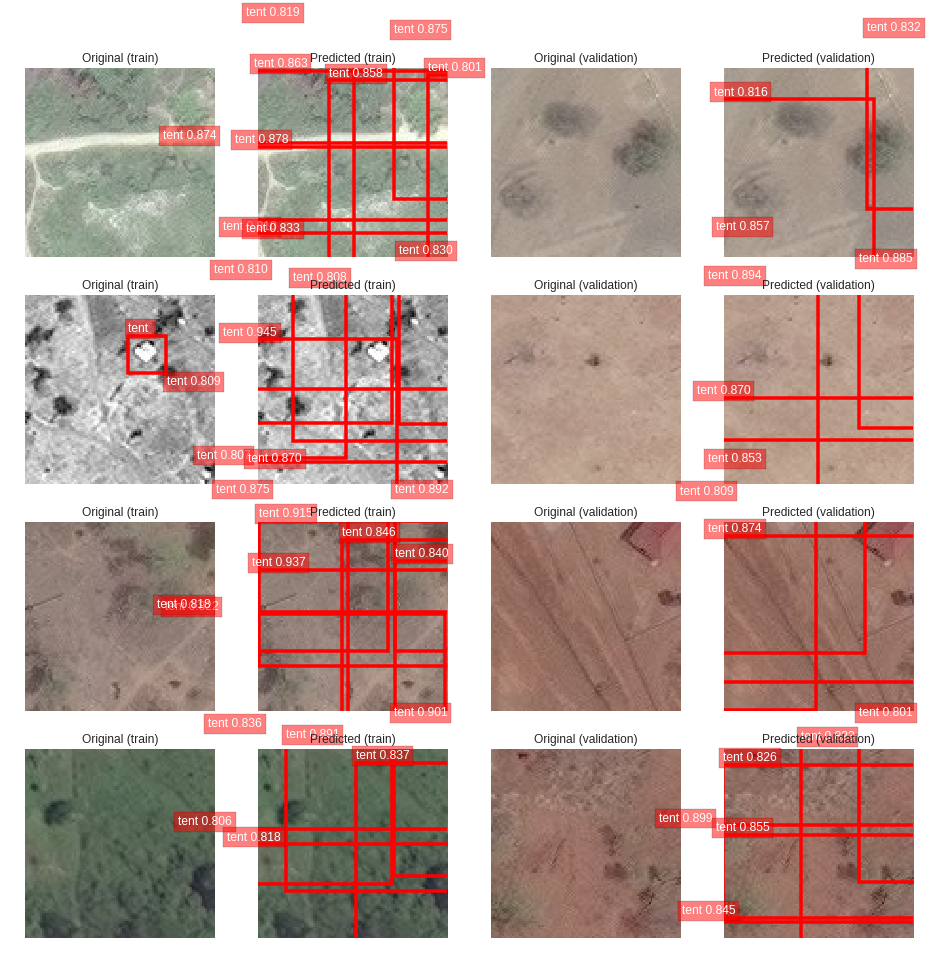

In [10]:
# Now that we loaded a model that hasn't been finetuned yet, let's look at what
# it gives us out of the box (Note: should not look good!)
show_examples(net, val_dataset, val_dataset, num_examples=4, threshold=0.8)

## Finetuning Through Training

By loading from fully pre-trained models, you are not only loading base network weights
(mobilenet for example), but also some additional blocks for object detection specifically.

Pretrained model from detection task is more relavant and adaptive than ``pretrained_base``
network which is usually trained on ImageNet for image classification task.

Therefore finetuning may converge significantly faster and better in some situations.



In [0]:
train_data = get_dataloader(net, train_dataset, IM_SIZE, 8, 0)

Try use GPU for training - note that you can change the run time to GPU or even TPU for colab



In [12]:
try:
  a = mx.nd.zeros((1,), ctx=mx.gpu(0))
  ctx = [mx.gpu(0)]
except:
  print("Using CPU instead!")
  ctx = [mx.cpu()]

mx.random.seed(1234)

Using CPU instead!


In [0]:
# Restart the net, set up the params and loss for training
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(
    net.collect_params(), 'sgd',
    {'learning_rate': 0.001, 'wd': 0.0005, 'momentum': 0.9, 'clip_gradient': 0.001})

mbox_loss = gcv.loss.SSDMultiBoxLoss()
ce_metric = mx.metric.Loss('CrossEntropy')
smoothl1_metric = mx.metric.Loss('SmoothL1')
max_steps = len(train_dataset)

# Here we just use one epoch as an example to train with. For finetuning you
# actually don't need to train over many epochs as you won't be training all the
# parameters in the model!
num_epochs = 1

In [14]:
# TRAINING CODE
# This is the densest code in the colab, since we are iterating through each
# example here for each epoch and modifying our net based on our loss that we
# set up in the previous cell. Note that the training is not always stable on
# colab, so sometimes layers will get NaN values. Because training is not
# visibly affected by this, we built in checks that will stop training if this
# problem arises (if it does, it will happen early on). Don't worry if this
# happens - often times just restarting the runtime and trying again will work!
for epoch in range(num_epochs):
  ce_metric.reset()
  smoothl1_metric.reset()
  tic = time.time()
  btic = time.time()
  net.hybridize(static_alloc=True, static_shape=True)
  for i, batch in enumerate(train_data):
    if i > max_steps:
      break
    batch_size = batch[0].shape[0]
    data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
    cls_targets = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)
    box_targets = gluon.utils.split_and_load(batch[2], ctx_list=ctx, batch_axis=0)
    with autograd.record():
      cls_preds = []
      box_preds = []
      for x in data:
          cls_pred, box_pred, _ = net(x)
          cls_preds.append(cls_pred)
          box_preds.append(box_pred)
      sum_loss, cls_loss, box_loss = mbox_loss(
          cls_preds, box_preds, cls_targets, box_targets)
      autograd.backward(sum_loss)
      all_nans = np.sum([1 for p in net.collect_params().values() if np.all(np.isnan(p._data[0].asnumpy()))])
      if all_nans > 0:
        print("There are %d all-NaN layers!" % all_nans)
        break
    # since we have already normalized the loss, we don't want to normalize
    # by batch-size anymore
    trainer.step(1)
    ce_metric.update(0, [l * batch_size for l in cls_loss])
    smoothl1_metric.update(0, [l * batch_size for l in box_loss])
    name1, loss1 = ce_metric.get()
    name2, loss2 = smoothl1_metric.get()
    if i % 20 == 0:
        print('[Epoch {}][Batch {}], Speed: {:.3f} samples/sec, {}={:.3f}, {}={:.3f}'.format(
            epoch, i, batch_size/(time.time()-btic), name1, loss1, name2, loss2))
    btic = time.time()

[Epoch 0][Batch 0], Speed: 6.461 samples/sec, CrossEntropy=4.233, SmoothL1=10.565
[Epoch 0][Batch 20], Speed: 3.425 samples/sec, CrossEntropy=3.964, SmoothL1=13.008
[Epoch 0][Batch 40], Speed: 3.501 samples/sec, CrossEntropy=3.645, SmoothL1=12.342
[Epoch 0][Batch 60], Speed: 3.451 samples/sec, CrossEntropy=3.427, SmoothL1=11.889
[Epoch 0][Batch 80], Speed: 3.498 samples/sec, CrossEntropy=3.281, SmoothL1=11.182
[Epoch 0][Batch 100], Speed: 3.516 samples/sec, CrossEntropy=3.162, SmoothL1=10.710
[Epoch 0][Batch 120], Speed: 3.498 samples/sec, CrossEntropy=3.071, SmoothL1=10.108
[Epoch 0][Batch 140], Speed: 3.486 samples/sec, CrossEntropy=2.987, SmoothL1=9.566
[Epoch 0][Batch 160], Speed: 3.413 samples/sec, CrossEntropy=2.921, SmoothL1=9.105
[Epoch 0][Batch 180], Speed: 3.457 samples/sec, CrossEntropy=2.861, SmoothL1=8.729
[Epoch 0][Batch 200], Speed: 3.448 samples/sec, CrossEntropy=2.810, SmoothL1=8.380
[Epoch 0][Batch 220], Speed: 3.433 samples/sec, CrossEntropy=2.757, SmoothL1=8.089
[Ep

### Qualitative Evaluation

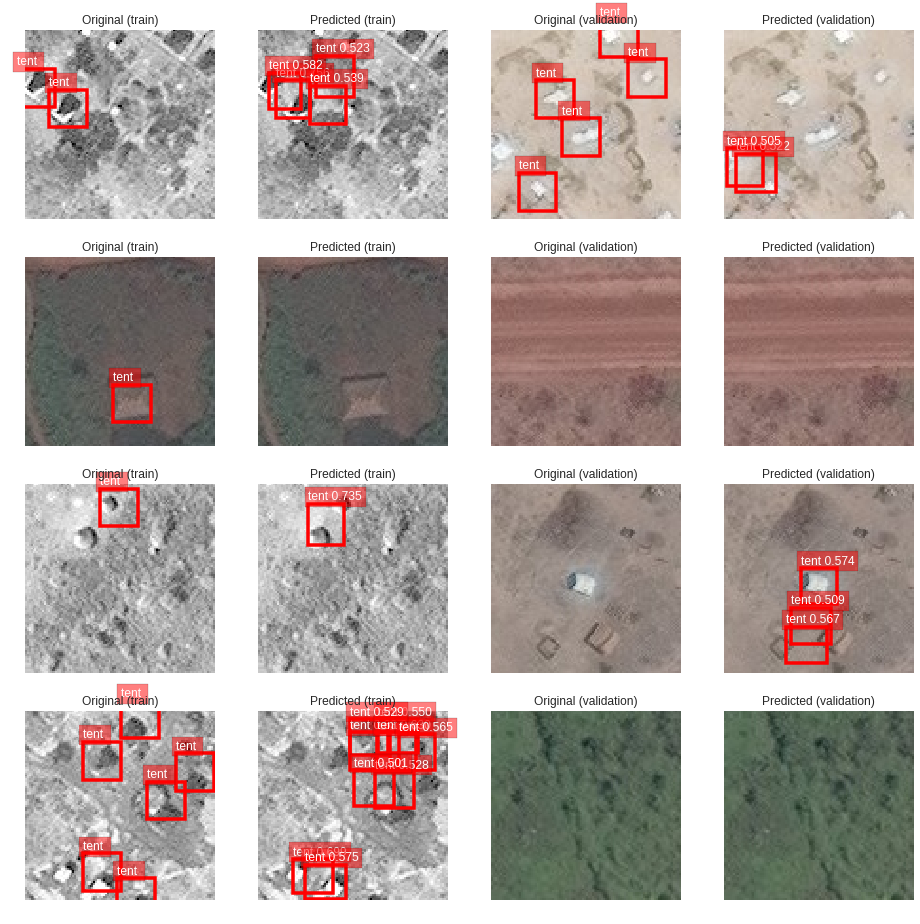

In [16]:
# Let's save these parameters locally first
net.save_parameters('tmp.params')

# Now let's evaluate these finetuned params by reloading it in to a fresh model
# and running it over some train/validation examples
net = gcv.model_zoo.get_model(MODEL, pretrained=True)
net.reset_class(classes)
net.load_parameters('tmp.params')
show_examples(net, train_dataset, val_dataset, num_examples=4, threshold=0.5)

### Saving Model Params to the Cloud

In [17]:
# This is the directory in the cloud we want to save the model to - change to
# <your_name>_models/...
model_name = '%s.params' % (MODEL.replace('voc', REGION))
date_pattern = datetime.datetime.now().strftime('%Y%m%d')
local_path = model_name # just save it as it is
cloud_path = 'example_models/%s/%s' % (date_pattern, model_name)
print("Saving to %s" % cloud_path)

# Save model locally and in the cloud
net.save_parameters(local_path)
blob = bucket.blob(cloud_path)
blob.upload_from_filename(local_path)

Saving to example_models/20181125/ssd_512_resnet50_v1_Africa2.params


Predicting With Our Fine-Tuned Model
----------------------------
Look at some examples using finetuned weights



In [0]:
# Let's load a trained model for runnign some predictions. For this case,
# we are using the model we trained earlier
net = gcv.model_zoo.get_model(MODEL.replace('voc', 'custom'), classes=classes, pretrained_base=False)
blob = bucket.blob('example_models/%s/%s.params' % ('20181125', MODEL.replace('voc', REGION)))
blob.download_to_filename('tmp.params')
net.load_parameters('tmp.params')

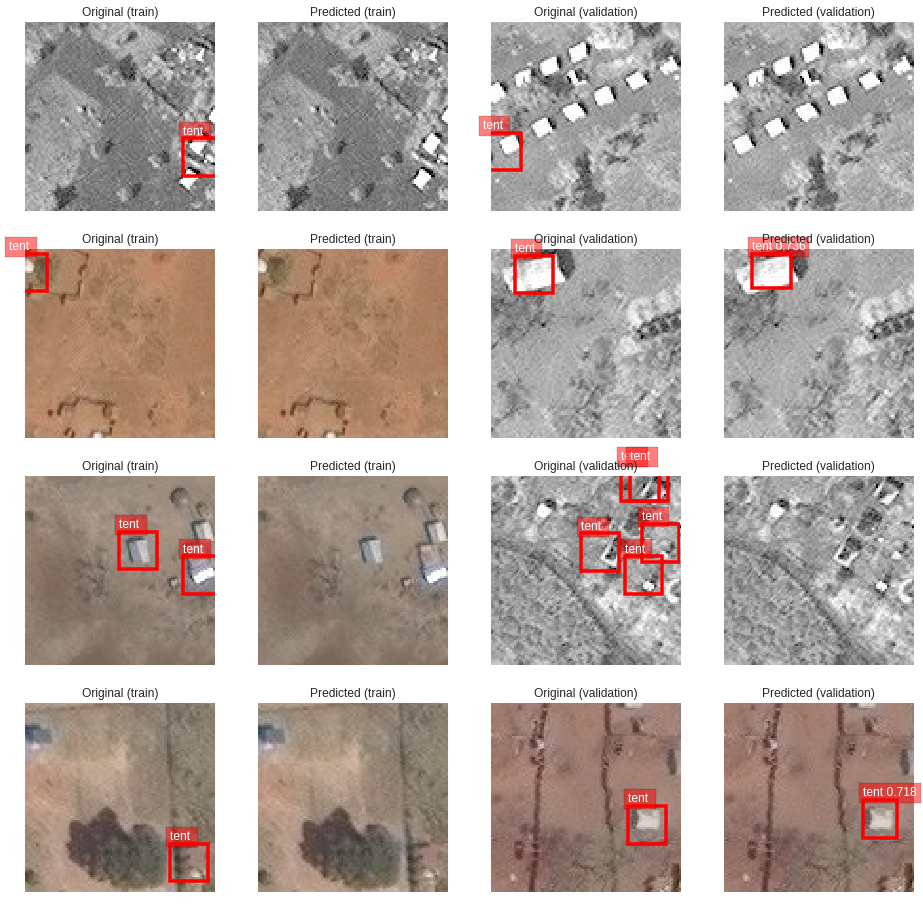

In [0]:
show_examples(net, train_dataset, val_dataset, num_examples=4, threshold=0.7)